In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm
import torch


# Helper functions

In [2]:
def plot_hist(returns, zeta, alpha, q, **kwargs):
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    qtl = np.quantile(returns, 1-q)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.title(f'$\\zeta$ = {zeta}, $\\alpha$={alpha}, q={q}')
    plt.axvline(var, c='y', linestyle='--', label=f'$VaR={var:4.4}$')
    plt.axvline(cvar, c='r', linestyle='--', label=f'$CVaR={cvar:4.4}$')
    plt.axvline(zeta, c='g', linestyle='--', label=f'$P(r\geq{zeta:.4})={p}$')
    plt.axvline(qtl, c='m', linestyle='--', label=f'$P(r\geq{qtl:.4})={q:.4}$')
    plt.legend()

In [3]:
def plot_2d(returns):
    
    N_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=N_assets, ncols=N_assets, figsize=(2 * N_assets + 2, 2 * N_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(N_assets):
        for j in range(N_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])

        # kde plot
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')

        # gaussian fit
        xs = np.linspace(np.min(returns[:, i]), np.max(returns[:, i]), 101)
        ys = norm.pdf(xs, loc=np.mean(returns[:, i]), scale=np.std(returns[:, i]))
        ax[i][i].plot(xs, ys, c='r', label='gaussian')

In [4]:
def get_var_cvar(returns, alpha):
    var = np.quantile(returns, alpha, axis=0)
    cvar = np.sum(returns * (returns <= var), axis=0) / np.sum(returns <= var, axis=0) / (1 - alpha)
    return var, cvar

# Generate returns

## Option 1: use generator

In [5]:
# original parameters from params.py

# N_pools = 6
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': 0.03 * np.ones(N_pools),
#           'x_0': 600,
#           'alpha': 0.05,
#           'q': 0.55,
#           'zeta': 0.05,
#           'batch_size': 1_000,
#           'kappa': np.array([0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
#           'sigma': np.array([1, 0.5, 0.5, 1.5, 1.75, 2, 2.25]),
#           'p': np.array([0.32, 0.34, 0.34, 0.33, 0.32, 0.31, 0.32]),
#           'T': 60,
#           'seed': 4294967143}

# in this test case return asset0 has lower return, but also lower CVaR
# so without return constraint, one should choose asset0, and as the constraint hits, one should gradually interpolated between 0 and 1

# N_pools = 2
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': np.array([0.03, 0.1]),
#           'x_0': 10,
#           'alpha': 0.05,
#           'q': 0.75,
#           'zeta': 0.05,
#           'batch_size': 1_000,
#           'kappa': np.array([0.5, 0.5, 0.5]),
#           'sigma': np.array([1., 2., 1.]),
#           'p': np.array([0.3, 0.35, 0.3]),
#           'T': 60,
#           'seed': 4294967143}

# 3 pools example

# N_pools = 3
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': np.array([0.03, 0.1, 0.03]),
#           'x_0': 10,
#           'alpha': 0.05,
#           'q': 0.85,
#           'zeta': 0.05,
#           'batch_size': 1_000,
#           'kappa': np.array([0.5, 1., 0.5, 0.5]),
#           'sigma': np.array([0.5, 2., 1., 2.]),
#           'p': np.array([0.3, 0.35, 0.3, 0.32]),
#           'T': 60,
#           'seed': 4294967143}

# 1 pool example

# N_pools = 1
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': np.array([0.03]),
#           'x_0': 10,
#           'alpha': 0.05,
#           'q': 0.85,
#           'zeta': 0.05,
#           'batch_size': 1_000,
#           'kappa': np.array([0.5, 0.5]),
#           'sigma': np.array([1., 1.]),
#           'p': np.array([0.3, 0.3]),
#           'T': 60,
#           'seed': 4294967143}

# 2 equal pools

N_pools = 2

params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': np.array([0.03, 0.03]),
          'x_0': 200.,
          'alpha': 0.05,
          'q': 0.6,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([0.5, 0.5, 0.5]),
          'sigma': np.array([1., 1., 1.]),
          'p': np.array([0.35, 0.35, 0.35]),
          'T': 60,
          'seed': 4294967143}

In [113]:
def generate_returns(params, weights=None):

    np.random.seed(params['seed'])

    pools = amm(Rx=params['Rx0'], Ry=params['Ry0'], phi=params['phi'])

    if weights is None:
        weights = np.repeat(1./params['N_pools'], params['N_pools'])
    
    xs_0 = weights * params['x_0']
    l = pools.swap_and_mint(xs_0)
    
    end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(params['kappa'], params['p'], params['sigma'], T=params['T'], batch_size=params['batch_size'])
    
    x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
    returns = np.log(x_T) - np.log(xs_0)

    return returns

## Option 2: use custom Gaussian returns

In [115]:
# try normal returns instead

def generate_gaussian_returns(params):

    np.random.seed(params['seed'])

    # 2 pools
    returns = np.array((0.07, 0.05)) + np.random.standard_normal((1000, params['N_pools'])) * np.array((0.05, 0.03))[None, :]
    
    # # # 3 pools
    # # returns = np.array((0.07, 0.05, 0.08)) + np.random.standard_normal((1000, params['N_pools'])) * np.array((0.05, 0.03, 0.07))[None, :]
    
    # # 6 pools
    # returns = np.array((0.07, 0.05, 0.08, 0.07, 0.05, 0.08)) + np.random.standard_normal((1000, params['N_pools'])) * np.array((0.05, 0.03, 0.07, 0.05, 0.03, 0.07))[None, :]

    return returns

# Visualize returns

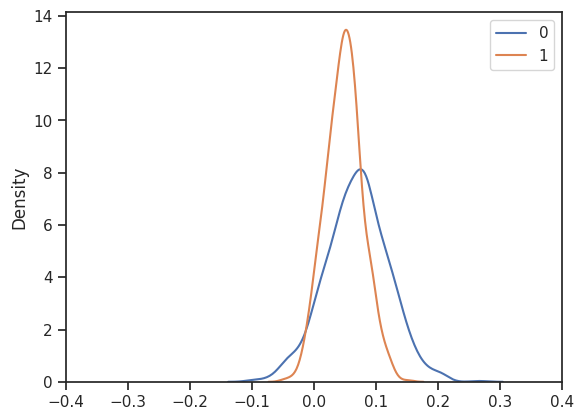

In [122]:
# 1d marginals on top of each other
returns = generate_returns(params)

for i in range(returns.shape[1]):
    sns.kdeplot(returns[:, i], label=i)
    
plt.xlim((-0.4, 0.4))
plt.legend()

In [123]:
mean = returns.mean(axis=0)
std = returns.std(axis=0)
var = np.quantile(returns, params['alpha'], axis=0)
cvar = np.sum(returns * (returns <= var[None, :]), axis=0) / np.sum(returns <= var[None, :], axis=0) / (1 - params['alpha'])
emp_cdf = np.mean(returns >= params['zeta'], axis=0)
normal_cdf = np.array([1 - norm.cdf(params['zeta'], loc=np.mean(returns[:, i]), scale=np.std(returns[:, i])) for i in range(params['N_pools'])])
df = pd.DataFrame([mean, std, cvar, emp_cdf, normal_cdf], index=['Mean', 'Std', 'Marginal CVaR', f"Empirical Marginal CDF @ {params['zeta']}:", f"Normal Marginal CDF @ {params['zeta']}:"])
display(df.style.background_gradient(cmap='coolwarm', axis=1))

print(f"Correlation matrix:")
corr = pd.DataFrame(np.corrcoef(returns.T))
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1
Mean,0.069240,0.048305
Std,0.050737,0.030247
Marginal CVaR,-0.041883,-0.013562
Empirical Marginal CDF @ 0.05:,0.656000,0.486000
Normal Marginal CDF @ 0.05:,0.647732,0.477660


Correlation matrix:


,0,1
0,1.000000,0.070337
1,0.070337,1.000000


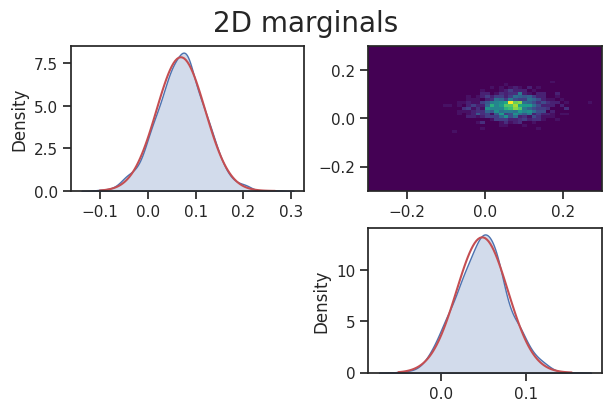

In [124]:
plot_2d(returns)

# Visualization of feasible region for N_pools = 3

In [59]:
assert params['N_pools'] == 3

N_points = 201

ws0 = np.linspace(0, 1, N_points)
ws1 = np.linspace(0, 1, N_points)
WS0, WS1 = np.meshgrid(ws0, ws1)
WS2 = 1. - WS0 - WS1
R = (WS0[None, :, :] * returns[:, 0][:, None, None]) + (WS1[None, :, :] * returns[:, 1][:, None, None]) + (WS2[None, :, :] * returns[:, 2][:, None, None])
M1 = np.mean(R >= params['zeta'], axis=0)
M2 = np.array([[i + j < 1. for i in ws0] for j in ws1])

AssertionError: 

In [60]:
assert params['N_pools'] == 3

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

pos = ax[0].imshow(M1, extent=[0, 1, 0, 1], origin='lower')
plt.colorbar(pos, ax=ax[0])
ax[0].set_xlabel('w0')
ax[0].set_ylabel('w1')

ax[0].imshow(M2, extent=[0, 1, 0, 1], alpha=0.2, origin='lower')
ax[0].set_title(f"$\zeta = {params['zeta']}$")

pos = ax[1].contourf(WS0, WS1, M1, levels=10)
plt.colorbar(pos, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('w0')
ax[1].set_ylabel('w1')
ax[1].set_title(f"$\zeta = {params['zeta']}$")


AssertionError: 

# Average of quantiles vs. quantiles of averages

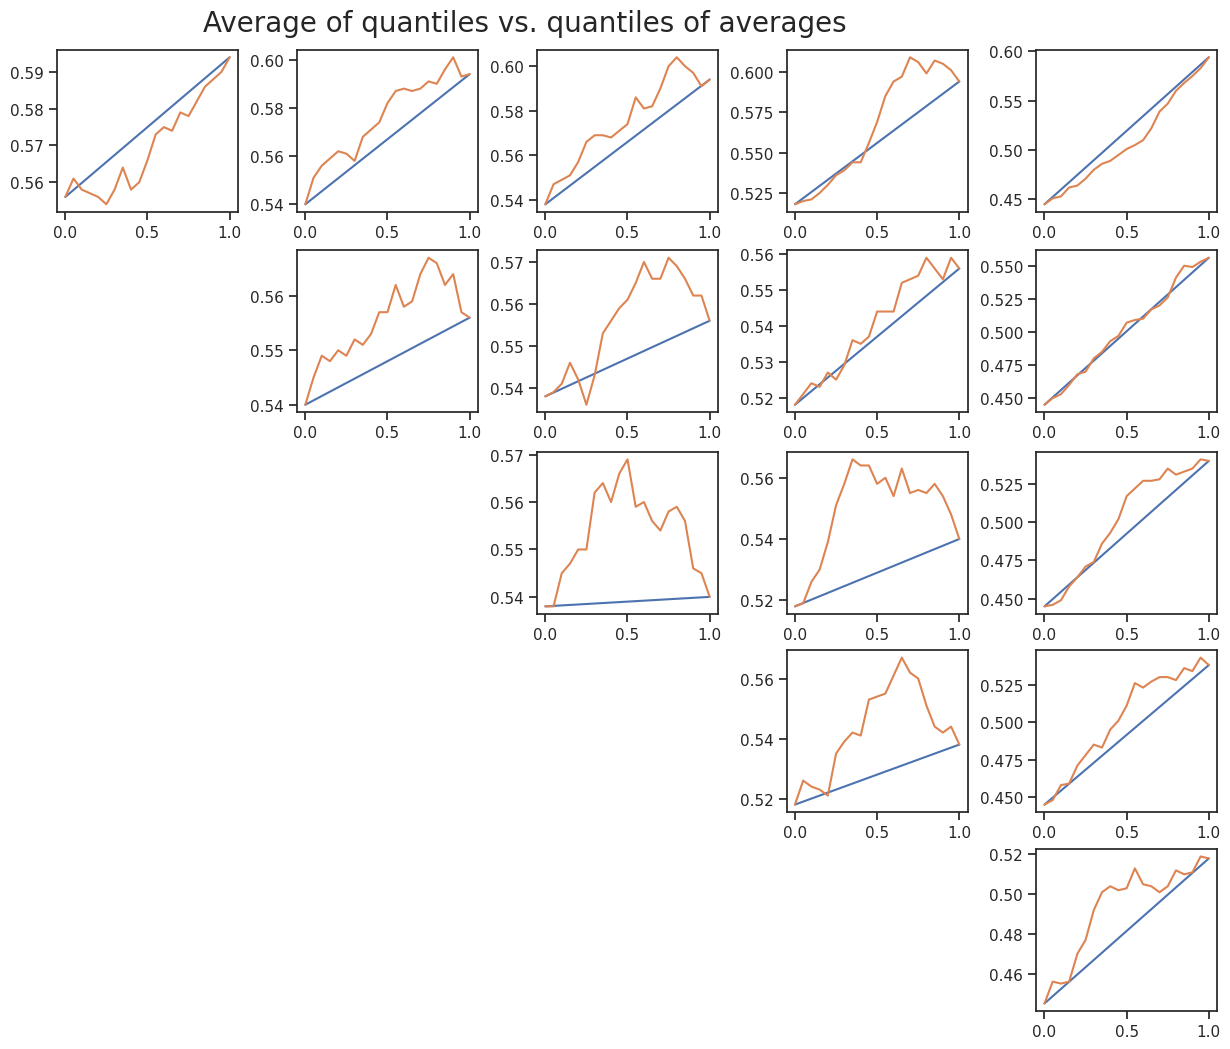

In [64]:
fig, ax = plt.subplots(nrows=N_pools, ncols=N_pools, figsize=(2 * N_pools + 2, 2 * N_pools), constrained_layout=True)
fig.suptitle('Average of quantiles vs. quantiles of averages', fontsize=20)

for i in range(N_pools):
    for j in range(N_pools):
        if i < j:
            q0, q1 = np.mean(returns[:, i] >= params['zeta']), np.mean(returns[:, j] >= params['zeta'])

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ returns[:, i][None, :] + ((1 - ws[:, None]) @ returns[:, j][None, :]) >= params['zeta'], axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Optimization with riskfolio

In [65]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5
weights,0.384955,0.385977,0.093154,0.116432,0.012557,0.006925


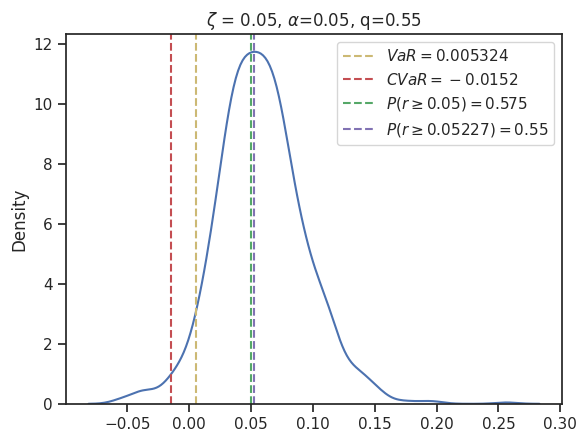

In [68]:
# Building the portfolio object
port = rp.Portfolio(returns=pd.DataFrame(returns))

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = returns @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns, **params)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

## Algorithms

### Convex optimizer

Linear inequality with second-order constraints:

- consider $a^T x \leq b$, with $a \sim \mathcal{N}(\bar{a}, \Sigma)$
- then $a^T x-b \sim \mathcal{N}\left(\bar{a}^T x-b, x^T \Sigma x\right)$
- hence
$$
\operatorname{Prob}\left(a^T x \leq b\right)=\Phi\left(\frac{b-\bar{a}^T x}{\sqrt{x^T \Sigma x}}\right)
$$
- and so
$$
\operatorname{Prob}\left(a^T x \leq b\right) \geq \eta \Longleftrightarrow b-\bar{a}^T x \geq \Phi^{-1}(\eta)\left\|\Sigma^{1 / 2} x\right\|_2
$$
a second-order cone constraint for $\eta \geq 0.5$ (i.e., $\Phi^{-1}(\eta) \geq 0$ )

In [168]:
def cvx(returns, params, mode):

    assert params['q'] > 0.5

    weights = cp.Variable((params['N_pools'],))
    X = returns @ weights
    
    Z = cp.Variable((params['batch_size'],))
    var = cp.Variable((1,))
    cvar = var + 1. / (params['alpha'] * params['batch_size']) * cp.sum(Z)

    # generic weight constraints
    constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

    # CVaR constraints
    constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

    # additional constraints (e.g. chance)
    if mode == 0:
        pass # unconstrained
    elif mode == 1:
        emp_cdf = np.mean(returns >= params['zeta'], axis=0)
        constraints += [emp_cdf @ weights * 1000 >= params['q'] * 1000]
    elif mode == 2:
        mean, cov = np.mean(returns, axis=0), np.cov(returns.T)
        sqrtcov = sqrtm(cov)
        constraints += [cp.SOC((-params['zeta'] + mean @ weights) / norm.ppf(params['q']), sqrtcov @ weights)]

    objective = cp.Minimize(cvar * 1000)
    
    # possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver="SCS")
                
    return weights.value,


### Gradient descent with pytorch

In [199]:
def gradient_descent(returns, params):

    dtype = torch.float
    device = torch.device("cpu")
    
    returns_t = torch.tensor(returns, device=device, dtype=dtype)

    weights_t = np.random.random(params['N_pools'])
    weights_t /= np.sum(weights_t)
    weights_t = torch.tensor(weights_t, device=device, dtype=dtype, requires_grad=True)
    
    learning_rate = 1e-2
    
    all_losses = torch.empty((0, 4))
    all_weights = torch.empty((0, params['N_pools']))
        
    for t in range(2000):
        
        portfolio_returns = returns_t @ weights_t / torch.sum(weights_t)
    
        var = torch.quantile(portfolio_returns, params['alpha'], axis=0)
        cvar = torch.sum(portfolio_returns * (portfolio_returns <= var), axis=0) / torch.sum(portfolio_returns <= var, axis=0) / (1 - params['alpha'])
    
        # chance constraint
        # loss1 = (torch.mean((portfolio_returns >= zeta).float()) - q) ** 2
        loss1 = torch.relu(params['q'] - torch.mean(torch.sigmoid(1000 * (portfolio_returns - params['zeta'])))) ** 2
    
        # ensure that weights not negative
        loss2 = torch.mean(torch.relu(-weights_t))
    
        # ensure that weights sum to one
        loss3 = torch.square(torch.sum(weights_t) - 1.)
            
        # CVaR constraints
        loss4 = -cvar
    
        # total loss
        loss = 1e3*loss1 + loss2 + loss3 + loss4
    
        all_losses = torch.cat([all_losses, torch.tensor([loss1, loss2, loss3, loss4]).reshape(1, -1)])
        all_weights = torch.cat([all_weights, weights_t.reshape(1, -1)])
    
        loss.backward()
        with torch.no_grad():
            weights_t -= learning_rate * weights_t.grad
            weights_t.grad = None
    
    weights_n = weights_t.detach().numpy()
    weights_n /= np.sum(weights_n)

    return weights_n, all_losses.detach().numpy()

In [184]:
weights, *_ = grad_descent(returns, {**params, 'q': 0.65})
np.mean(returns @ weights >= params['zeta'])

0.649

## Run algorithms

In [185]:
N_points = 21
N_algorithms = 4
N_metrics = 2

qs = np.linspace(0.51, 0.71, N_points)

results_weights = np.full((N_points, N_algorithms, params['N_pools']), np.nan)
results_metrics = np.full((N_points, N_algorithms, N_metrics), np.nan)

returns = generate_gaussian_returns(params)

for i, q in tqdm(enumerate(qs)):

    algorithms = []
    
    # unconstrained, for demostration purposes
    algorithms += [{'func': cvx, 'kwargs': {'mode': 0}}]
    
    # lower bound: average of emp cdf: - might not be a valid constraint! unless VaR subadditive
    algorithms += [{'func': cvx, 'kwargs': {'mode': 1}}]
    
    # normal approximation with SOC constraint
    algorithms += [{'func': cvx, 'kwargs': {'mode': 2}}]

    # backprop
    algorithms += [{'func': gradient_descent, 'kwargs': {}}]

    N_completed = 0

    for j, algorithm in enumerate(algorithms):
        
        try:

            func, kwargs = algorithm['func'], algorithm['kwargs']
            
            portfolio_weights, *_ = func(returns, {**params, 'q': q}, **kwargs)
            portfolio_returns = returns @ portfolio_weights
            var, cvar = get_var_cvar(portfolio_returns, params['alpha'])
    
            results_weights[i, j, :] = portfolio_weights
            results_metrics[i, j, 0] = cvar
            results_metrics[i, j, 1] = np.mean(portfolio_returns >= params['zeta'])
    
            N_completed += 1
                
        except Exception as e:
            print(f"Algorithm {j} failed for q={q:.2f}: {e}")
            continue

    # if failed for all constraints apart from unconstrained, break
    if N_completed <= 1:
        break

14it [00:50,  3.73s/it]

Algorithm 2 failed for q=0.65: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


15it [00:53,  3.56s/it]

Algorithm 1 failed for q=0.66: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.66: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


16it [00:56,  3.46s/it]

Algorithm 1 failed for q=0.67: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.67: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


17it [00:59,  3.34s/it]

Algorithm 1 failed for q=0.68: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.68: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


18it [01:03,  3.25s/it]

Algorithm 1 failed for q=0.69: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.69: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


19it [01:06,  3.19s/it]

Algorithm 1 failed for q=0.70: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.70: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


20it [01:09,  3.13s/it]

Algorithm 1 failed for q=0.71: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)
Algorithm 2 failed for q=0.71: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


21it [01:12,  3.43s/it]


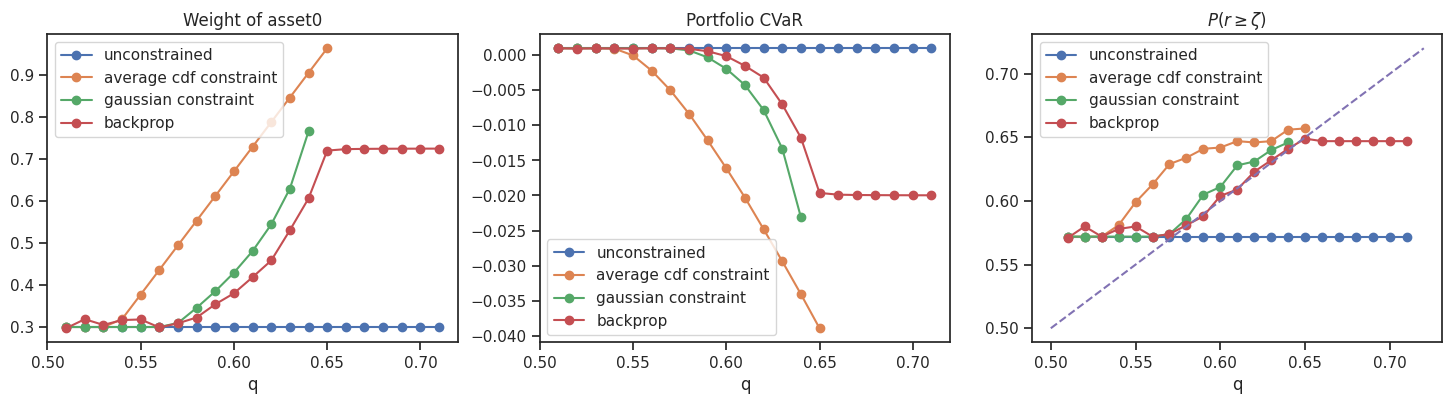

In [186]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))

ax[0].set_title('Weight of asset0')
ax[0].plot(qs, results_weights[:, 0, 0], marker='o', label='unconstrained')
ax[0].plot(qs, results_weights[:, 1, 0], marker='o', label='average cdf constraint')
ax[0].plot(qs, results_weights[:, 2, 0], marker='o', label='gaussian constraint')
ax[0].plot(qs, results_weights[:, 3, 0], marker='o', label='backprop')
ax[0].set_xlabel('q')
ax[0].legend()

ax[1].set_title('Portfolio CVaR')
ax[1].plot(qs, results_metrics[:, 0, 0], marker='o', label='unconstrained')
ax[1].plot(qs, results_metrics[:, 1, 0], marker='o', label='average cdf constraint')
ax[1].plot(qs, results_metrics[:, 2, 0], marker='o', label='gaussian constraint')
ax[1].plot(qs, results_metrics[:, 3, 0], marker='o', label='backprop')
ax[1].set_xlabel('q')
ax[1].legend()

ax[2].set_title('$P(r \geq \zeta)$')
ax[2].plot(qs, results_metrics[:, 0, 1], marker='o', label='unconstrained')
ax[2].plot(qs, results_metrics[:, 1, 1], marker='o', label='average cdf constraint')
ax[2].plot(qs, results_metrics[:, 2, 1], marker='o', label='gaussian constraint')
ax[2].plot(qs, results_metrics[:, 3, 1], marker='o', label='backprop')

x0, x1 = ax[2].get_xlim()
qs_plot = np.linspace(x0, x1, 101)
ax[2].plot(qs_plot, qs_plot, ls='--')
ax[2].set_xlabel('q')
ax[2].legend()

# Iterative market impact approach

In [ ]:
weights = np.repeat(1., params['N_pools']) / params['N_pools']

all_weights = np.empty((0, params['N_pools']))
all_results = np.empty((0,))

for _ in range(20):
    
    returns = generate_returns(params, weights)
    var, cvar = get_var_cvar(returns @ weights, params['alpha'])
    
    all_weights = np.vstack([all_weights, weights.reshape(1, -1)])
    all_results = np.append(all_results, cvar)
    
    weights, *_ = gradient_descent(returns, params)

all_weights = np.array(all_weights)
all_cvars = np.array(all_cvars)

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].scatter(all_weights[:, 0], all_weights[:, 1], marker='x')
ax[0].set_title(f"w0, w1; x0 = {params['x_0']}; Rx0 = {params['Rx0']}")
ax[0].set_xlabel('w0')
ax[0].set_ylabel('w1')
ax[1].plot(all_results, marker='o')
ax[1].set_title(f"CVaR; x0 = {params['x_0']}; Rx0 = {params['Rx0']}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 129.81it/s]
